# Example of analyzing in parallel a Zarr image from a public S3 repository

The images are taken from  the paper "In Toto Imaging and Reconstruction of Post-Implantation Mouse Development at the Single-Cell Level" published October 2018 in Cell: https://doi.org/10.1016/j.cell.2018.09.031

The images can be viewed online in the [Image Data Resource](http://idr.openmicroscopy.org/webclient/?show=project-502).

In [37]:
import dask
import dask.array as da
import dask_image.ndfilters
import dask_image.ndmeasure
from omero.gateway import BlitzGateway

import matplotlib.pyplot as plt
%matplotlib inline

The Zarr data is stored separately from the IDR, on an S3 object store.

### IDR image to analyze

In [38]:
image_id = 4007801

### Create a connection to IDR

In [39]:
HOST = 'ws://idr.openmicroscopy.org/omero-ws'
conn = BlitzGateway('public', 'public',
                    host=HOST, secure=True)
print(conn.connect())
conn.c.enableKeepAlive(60)

True


### Load image metadata from IDR

In [40]:
image = conn.getObject("Image", image_id)

### Load Zarr Image from S3

In [41]:
def load_binary_from_s3(id, resolution='4'):
    endpoint_url = 'https://s3.embassy.ebi.ac.uk/'
    root = 'idr/zarr/v0.1/%s.zarr/%s/' % (id, resolution)
    return da.from_zarr(endpoint_url + root)

In [42]:
data = load_binary_from_s3(image_id)

### Segment the image

In [43]:
def analyze(t, c, z):
    plane = data[t, c, z, :, :] 
    smoothed_image = dask_image.ndfilters.gaussian_filter(plane, sigma=[1, 1])
    threshold_value = 0.75 * da.max(smoothed_image).compute()
    threshold_image = smoothed_image > threshold_value
    label_image, num_labels = dask_image.ndmeasure.label(threshold_image)
    name = "t:%s, c: %s, z:%s" % (t, c, z)
    return label_image, name

### Use Dask Delayed 

We use ``dask.delayed`` on our function so it records what we want to compute as a task into a graph that will run later on parallel hardware

In [45]:
lazy_results = []
middle_z = image.getSizeZ() // 2
middle_t = image.getSizeT() // 2
range_t = 5
range_z = 5
range_c = 1
for t in range(middle_t - range_t, middle_t + range_t):
    for z in range(middle_z - range_z, middle_z + range_z):
        for c in range(range_c):
            lazy_result = dask.delayed(analyze)(t, c, z)
            lazy_results.append(lazy_result)
print(lazy_results)

[Delayed('analyze-162d8087-7062-4703-8f21-ceb749d266b6'), Delayed('analyze-09df190d-863a-4024-aa3a-cc6cdf3099c8'), Delayed('analyze-83c8dac3-23d6-4e89-a07b-cbd9ec7a130f'), Delayed('analyze-6067fffc-f2c5-4d64-b818-11cbc72da834'), Delayed('analyze-d395dac6-21b4-46b2-b738-1c29e9b751e9'), Delayed('analyze-5654a72e-2bc0-4872-b4d9-d84f88cbef95'), Delayed('analyze-fee2eeaf-bc1a-4837-89c3-b7ee3b9efc0e'), Delayed('analyze-15b3897e-7b9d-46aa-b581-e95d2e4bf77d'), Delayed('analyze-5c538543-93d2-481d-9557-00918d6cfd8e'), Delayed('analyze-73354b88-9a13-415d-8666-fa57489f66ca'), Delayed('analyze-5c610f6d-a6c7-4a00-a0f5-cc882b7b8f99'), Delayed('analyze-8c3c407d-8b02-432d-95fd-54a47f21771a'), Delayed('analyze-541b4fc1-82c8-4ebd-b1ae-6b1633a6cccf'), Delayed('analyze-66c9f283-4c80-45eb-a5d9-a5790c1ed49c'), Delayed('analyze-03ac4c8c-42d3-43cd-b54c-a562c8a18038'), Delayed('analyze-421f559c-61bd-4be9-8dda-f2431ac0239d'), Delayed('analyze-5265461e-7020-46d1-b420-45d4c41143e4'), Delayed('analyze-66929f1b-4e5a

### Run in parallel

The lazy_results list contains information about ``number_t*number_z*number_c`` calls to our function ``analyze`` that have not yet been run. We call ``dask.compute`` when we want the results.

In [46]:
%time results = dask.compute(*lazy_results)

CPU times: user 3.44 s, sys: 480 ms, total: 3.92 s
Wall time: 4.36 s


### Display 10 results

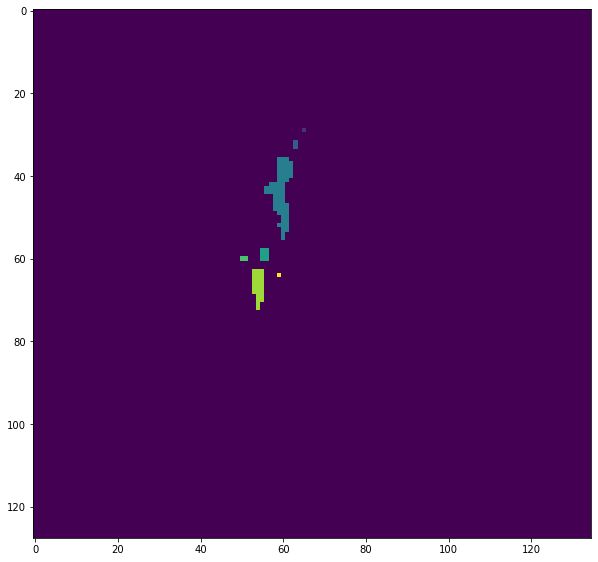

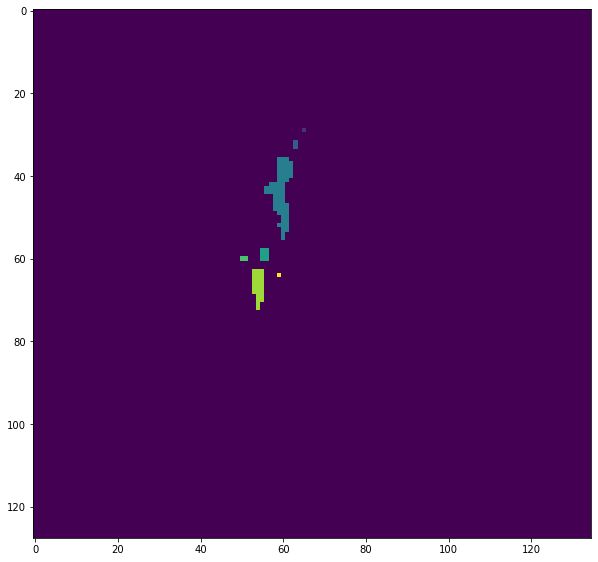

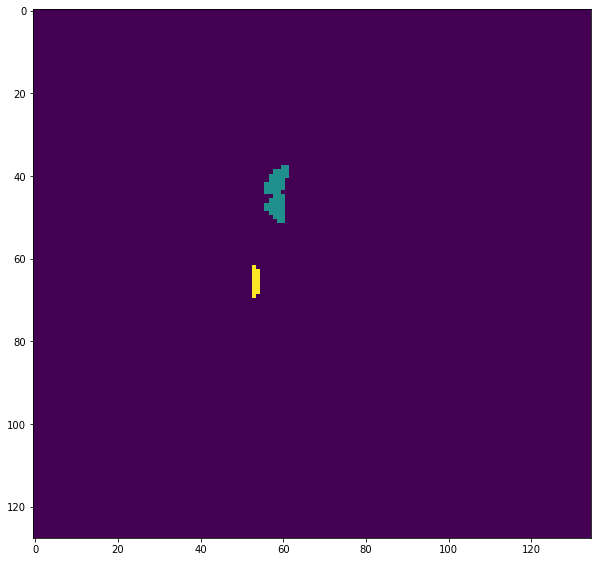

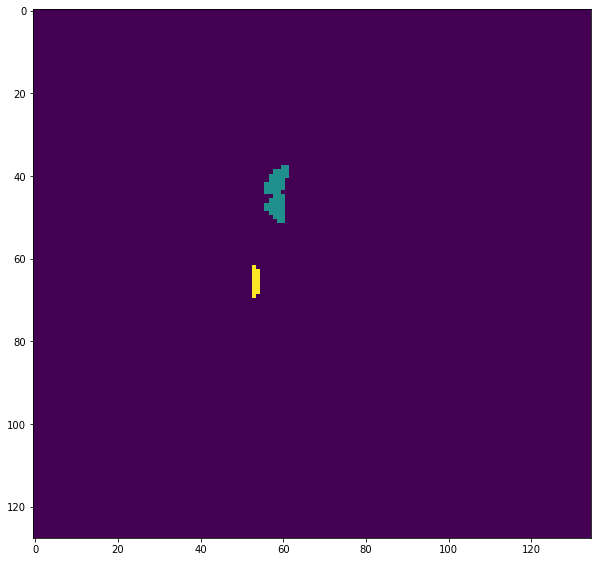

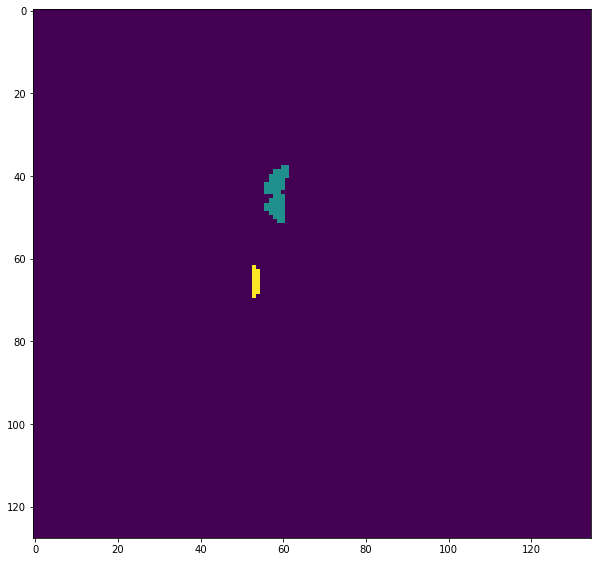

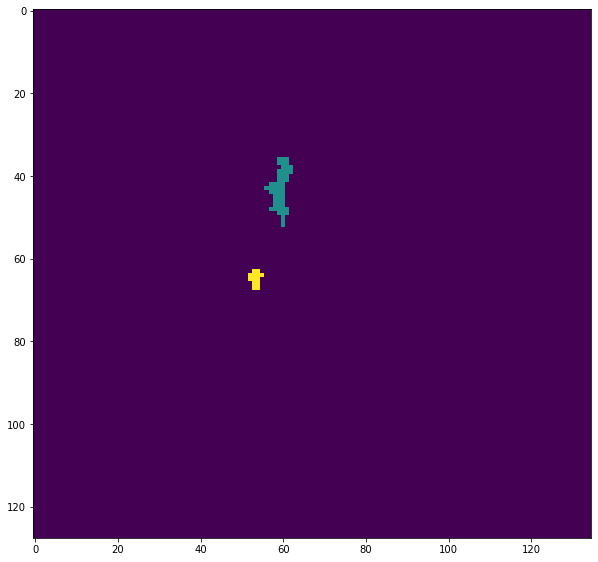

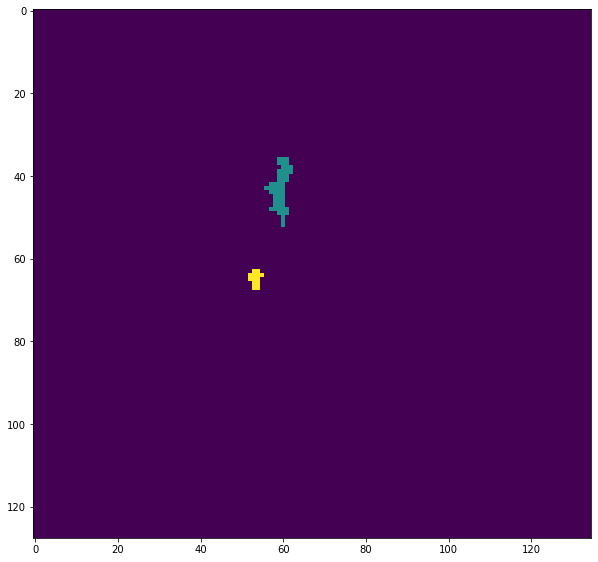

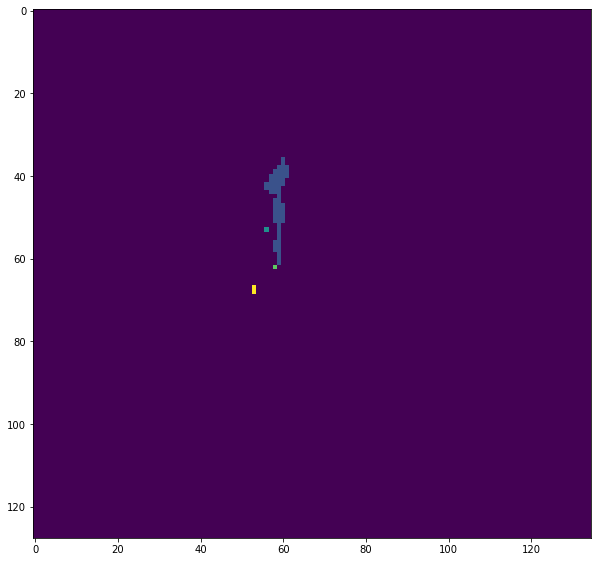

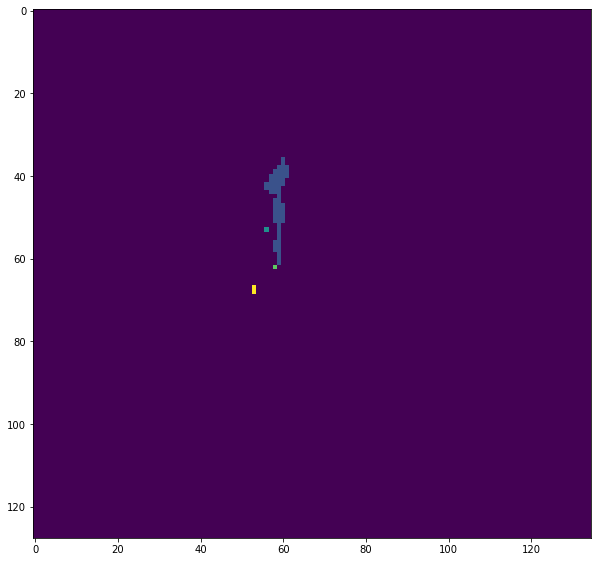

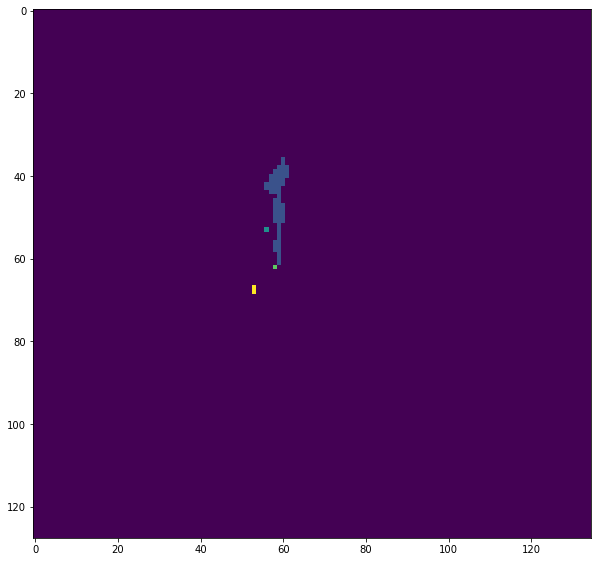

In [47]:
for r, name in results[:10]:
    plt.figure(figsize=(10, 10))
    plt.imshow(r)
    plt.title(name)

### Close the connection

In [13]:
conn.close()

### License
Copyright (C) 2020 University of Dundee. All Rights Reserved.
This program is free software; you can redistribute it and/or modify it
under the terms of the GNU General Public License as published by the
Free Software Foundation; either version 2 of the License, or
(at your option) any later version.
This program is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY
or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for
more details. You should have received a copy of the GNU General
Public License along with this program; if not, write to the
Free Software Foundation,
Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301 USA.